In [1]:
import pandas as pd

from fluxo.dados import Dados
from fluxo.carga_dados import CargaDados
from fluxo.limpeza_dados import LimpezaDados
from fluxo.preprocessamento import Preprocessamento
from fluxo.extracao_caracteristicas import ExtracaoCaracteristicas
from fluxo.treinamento import Treinamento
from fluxo.classificador import Classificador

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
pd.set_option('max_colwidth', 180)

## Carga de Dados

In [3]:
dados = Dados()

In [4]:
cg = CargaDados()
cg.executar(dados)

12:29:51 - Carregando dados de segmentos...
12:29:52 - 206488 registros carregados.


## Limpeza de Dados

In [5]:
lp = LimpezaDados(dados)
lp.executar(dados, 'Port.', reclassificar_nao_identificados=False)

12:29:52 - (Re)Carregando segmentos originais...
12:29:52 - Removendo segmentos nulos...
12:29:52 - 1900 segmentos nulos excluídos.
12:29:52 - Restaram 204588 segmentos não nulos.
12:29:52 - Removendo todos os segmentos do tipo Anexo...
12:29:52 - 5771 segmentos do tipo Anexo excluídos.
12:29:52 - Excluindo segmentos dos atos que não são Port....
12:29:52 - 143909 segmentos de atos não Port. excluídos.
12:29:52 - Restaram 54908 segmentos de atos Port..
12:29:52 - Removendo segmentos não representativos para o tipo Port....
12:29:52 - 1550 segmentos não representativos excluídos.
12:29:52 - Restaram 53358 segmentos representativos.
12:29:52 - Removendo tags HTML...
12:29:52 - Removendo caracteres de escape HTML...
12:29:52 - Limpeza de dados concluída.


## Preprocessamento

In [6]:
pp = Preprocessamento()
pp.executar(dados)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/91872936504/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
12:29:52 - Convertendo caracteres para minúsculo...
12:29:52 - Removendo pontuação...
12:29:53 - Realizando tokenização...
12:29:53 - Removendo stopwords...
12:29:55 - Removendo tokens menores que 2 caracteres...
12:29:55 - Reconstruindo texto a partir dos tokens...
12:29:55 - Preprocessamento concluído.


## Extração de Características

In [7]:
ec = ExtracaoCaracteristicas(dados)
ec.executar(dados)

12:29:55 - Executando vetorização TF-IDF...
12:29:57 - Executando vetorização TF-IDF para Cross-Validation...
12:29:59 - Extração de características concluída.


## Treinamento e Teste

In [8]:
t = Treinamento()

In [9]:
# Linear SVC (SVM)
estimadorSVC_1x1 = OneVsOneClassifier(LinearSVC(random_state=dados.random))
t.adicionar_modelo(Classificador('LinearSVC-1x1', estimadorSVC_1x1))
t.treinar_modelos(dados)

estimadorSVC_1xR = OneVsRestClassifier(LinearSVC(random_state=dados.random))
t.adicionar_modelo(Classificador('LinearSVC-1xR', estimadorSVC_1xR))
t.treinar_modelos(dados)

12:30:00 - Treinando modelos...
12:30:00 - Treinando modelos...


In [10]:
# Multinomial Naive Bayes 
estimadorNB_1x1 = OneVsOneClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1x1', estimadorNB_1x1))
t.treinar_modelos(dados)

estimadorNB_1xR = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR', estimadorNB_1xR))
t.treinar_modelos(dados)

12:30:03 - Treinando modelos...
12:30:06 - Treinando modelos...


## Treinamento e Teste com Cross-Validation

In [11]:
t = Treinamento()

In [12]:
# Linear SVC (SVM)
estimadorSVC_1x1_CV = OneVsOneClassifier(LinearSVC(random_state=dados.random))
t.adicionar_modelo(Classificador('LinearSVC-1x1-CV', estimadorSVC_1x1_CV))
t.treinar_modelos(dados, 5)

estimadorSVC_1xR_CV = OneVsRestClassifier(LinearSVC(random_state=dados.random))
t.adicionar_modelo(Classificador('LinearSVC-1xR-CV', estimadorSVC_1xR_CV))
t.treinar_modelos(dados, 5)

12:30:09 - Treinando modelos com cross-validation...
12:30:13 - Treinando modelos com cross-validation...


In [13]:
# Multinomial Naive Bayes 
estimadorNB_1x1_CV = OneVsOneClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1x1-CV', estimadorNB_1x1_CV))
t.treinar_modelos(dados, cv=5)

estimadorNB_1xR_CV = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR-CV', estimadorNB_1xR_CV))
t.treinar_modelos(dados, cv=5)

12:30:26 - Treinando modelos com cross-validation...
12:30:43 - Treinando modelos com cross-validation...


## Apresentação de Resultados

In [14]:
resultado = pd.DataFrame(dados.metricas)
resultado.transpose()

,acuracia,precisao,revocacao,f1
LinearSVC-1x1,0.8961,0.9131,0.8706,0.8894
LinearSVC-1xR,0.8953,0.9075,0.8783,0.8914
MultinomialNB-1x1,0.7399,0.8414,0.6516,0.6870
MultinomialNB-1xR,0.7511,0.8370,0.6881,0.7212
LinearSVC-1x1-CV,0.8413,0.8692,0.8111,0.8321
LinearSVC-1xR-CV,0.8387,0.8538,0.8141,0.8285
MultinomialNB-1x1-CV,0.6890,0.7810,0.6097,0.6338
MultinomialNB-1xR-CV,0.6999,0.7850,0.6410,0.6619


In [15]:
#print(resultado.transpose().to_latex())

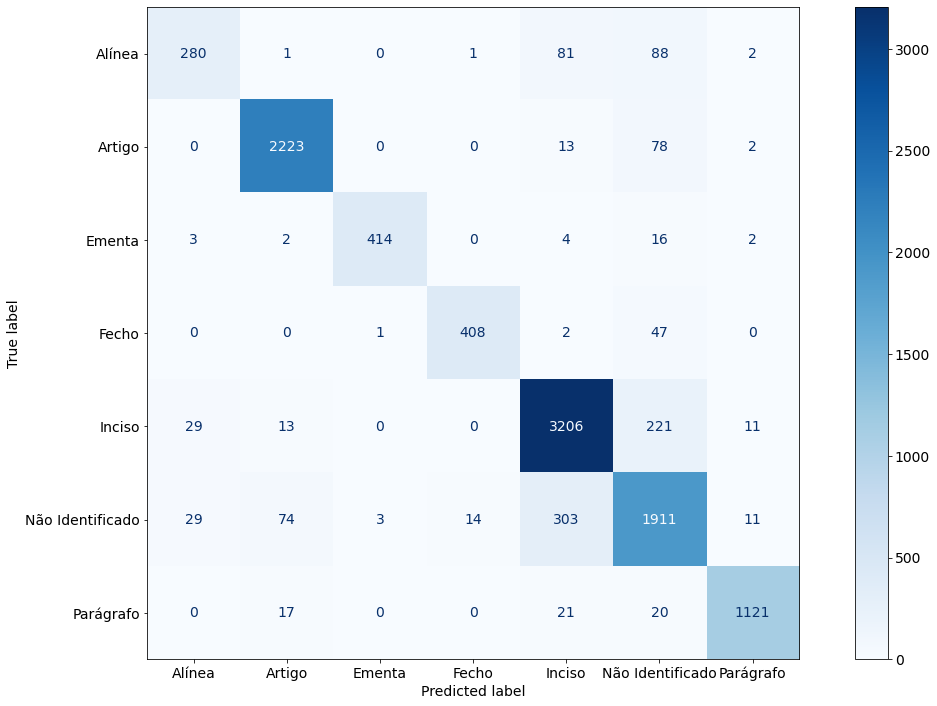

In [16]:
clf = Classificador('LinearSVC-1x1-CV', estimadorSVC_1x1_CV)
clf.treinar(dados)
clf.plotar_matriz_confusao(dados)